In [86]:
import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from bbpack import matplotlibrc

In [87]:
# Define and execute the ADQL query to crossmatch 2MASS with Gaia DR3 (Working Query)
query = f"""
SELECT *, (DISTANCE(132.825, 11.8, gaia.ra, gaia.dec)) AS ang_sep
FROM gaiadr3.gaia_source AS gaia
JOIN gaiaedr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiaedr3.tmass_psc_xsc_join AS xjoin
   ON xmatch.original_ext_source_id = xjoin.original_psc_source_id
JOIN gaiadr1.tmass_original_valid AS tmass
   ON xjoin.original_psc_source_id = tmass.designation
WHERE DISTANCE(132.825, 11.8, gaia.ra, gaia.dec) < 1.
AND gaia.phot_g_mean_mag < 13
ORDER BY ang_sep ASC
"""

# Upload the source_id table for crossmatching
job = Gaia.launch_job_async(query=query)
gaia = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [88]:
# Determine # of stars in query:
n_stars = len(gaia)
print(f'# of stars in query = {n_stars}')

# Determine # of stars with 2MASS ph_qual != 'AAA'
n_stars_ph_qual = len(gaia[gaia['ph_qual'] != 'AAA'])
print(f'# of stars with ph_qual != AAA: {n_stars_ph_qual}')

# Determine stars with negative parallax
n_stars_minus_parallax = len(gaia[gaia['parallax'] <= 0])
print(f'# of stars with negative parallax: {n_stars_minus_parallax}')

# Apply quality cuts from above
gaia_mod = gaia[(gaia['ph_qual'] == 'AAA') & (gaia['parallax'] > 0)]
print(f'# of stars left after quality cut: {len(gaia_mod)}')


# of stars in query = 485
# of stars with ph_qual != AAA: 13
# of stars with negative parallax: 0
# of stars left after quality cut: 467


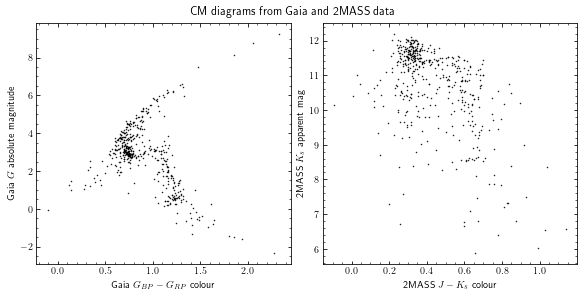

In [89]:
## Gaia CM diagram parameters
gaia_bp_rp_colour = gaia_mod['phot_bp_mean_mag']-gaia_mod['phot_rp_mean_mag'] # bp-rp colour

# Absolute G mag
distance_in_pc = 1/(gaia_mod['parallax']*10**(-3))
distance_mod = 5*np.log10(distance_in_pc/10)
abs_g_mag = gaia_mod['phot_g_mean_mag'] - distance_mod

## 2MASS CM diagram parameters
tmass_J_Ks_colour = gaia_mod['j_m'] - gaia_mod['ks_m']
app_j_mag = gaia_mod['j_m']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
ax1.scatter(gaia_bp_rp_colour, abs_g_mag, s=1, marker='.')
ax1.set_xlabel(r'Gaia $G_{BP} - G_{RP}$ colour')
ax1.set_ylabel(r'Gaia $G$ absolute magnitude')
ax2.scatter(tmass_J_Ks_colour, app_j_mag, s=1, marker='.')
ax2.set_xlabel(r'2MASS $J-K_s$ colour')
ax2.set_ylabel(r'2MASS $K_s$ apparent mag')
fig.suptitle('CM diagrams from Gaia and 2MASS data')
plt.savefig('./figures/cmds M67.png', dpi=200, bbox_inches='tight')
plt.show()

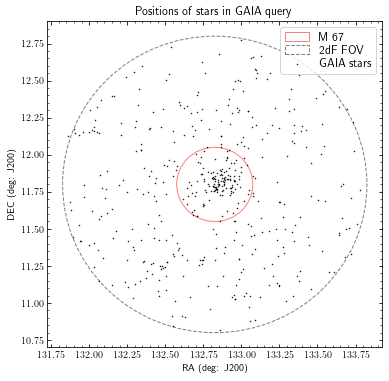

In [90]:
plt.figure(figsize=(6,6))
tdF = plt.Circle((132.825, 11.8), 1, facecolor='none', linestyle='--', edgecolor='k', alpha=0.5, label = '2dF FOV')
M67 = plt.Circle((132.825, 11.8), 15/60, facecolor='none', edgecolor='r', alpha=0.5, label = 'M 67')
plt.gca().add_patch(M67)
plt.gca().add_patch(tdF)
plt.scatter(gaia_mod['ra'], gaia_mod['dec'], s=1, marker='.', label = 'GAIA stars')
plt.xlabel('RA (deg: J200)')
plt.ylabel('DEC (deg: J200)')
plt.title('Positions of stars in GAIA query')
plt.legend()
plt.show()

## Discussion of usage of 2dF for potential observation run

### Star cluster apparent size & fibre crowding
The star cluster has an apparent size of approximately $30$ arcminutes, which corresponds to the object only covering $\sim 6\%$ of the 2dF instrument survey area. Given that the majority of stars are in this region there may be an issue with crowding of 2dF's 392 optical fibres in the small region they would need to cover on the 2dF fibre plate. An instrument with a smaller field of view may be more suitable for this target.

### Number of stars vs number of fibres
The total number of stars in the GAIA output is $\sim 20\%$ greater than the number of fibres available for 2dF. This may indicate that 2dF is not suitable for this observation, as an instrument with more fibres would be more efficient. However, it may be the case that not all 467 stars belong to the star cluster M 67. We have simply searched for all GAIA entries within 1 deg of M 67, so there is likely some contamination from foreground and background stars.